In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from scipy.stats import gaussian_kde

import torch
from torchmetrics.functional import spearman_corrcoef as spearman
from data import get_data

from intensity import get_intensities
from get_ssims import get_ssims

# Set Parameters

In [2]:
device = torch.device('cuda:7')
BATCH_SIZE = 1000

# Set Panel

In [3]:
ch2stain = {0:"DAPI", 1:"CD3", 2:"ERK-1", 3:"hRAD51", 4:"CyclinD1", 5:"VIM", 6:"aSMA", 7:"ECad", 8:"ER", 9:"PR",
            10:"EGFR", 11:"Rb", 12:"HER2", 13:"Ki67", 14:"CD45", 15:"p21", 16:"CK14", 17:"CK19", 18:"CK17",
            19:"LaminABC", 20:"AR", 21:"Histone H2AX", 22:"PCNA", 23:"PanCK", 24:"CD31"}

# Get Model Checkpoint and Panel Selection Order

In [4]:
ckpt = 'ckpts/50p_mask_12l_dec.ckpt' 

In [5]:
panel_order = [0,7,16,12,14,9,18,22,24,1,11,6,2,15,23,13,21,5,3,4,20,8,19,17]

# Load Model

In [6]:
from mae import IF_MAE
model = IF_MAE().load_from_checkpoint(ckpt)
model = model.to(device)
model = model.eval()

# Load Data

In [7]:
val_loader = get_data('BC', BATCH_SIZE)

# Run Model to get Mean Intensities and SSIMs

In [15]:
intensities = []
ssims = [] 
panel_sizes = [i for i in range(1, len(panel_order) + 1)] #iteration panels
for i,size in enumerate(panel_sizes):
    unmasked_ch_idx = panel_order[:size]
    mints, pmints = get_intensities(model, unmasked_ch_idx, val_loader, device=device)
    #ssims.append(get_ssims(model, unmasked_ch_idx, val_loader, device=device))
    intensities.append((mints, pmints))

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:41<00:00,  1.18s/it]


# Plot SSIM

In [11]:
for i in range(25):
    if i not in panel_order: print(i)

10


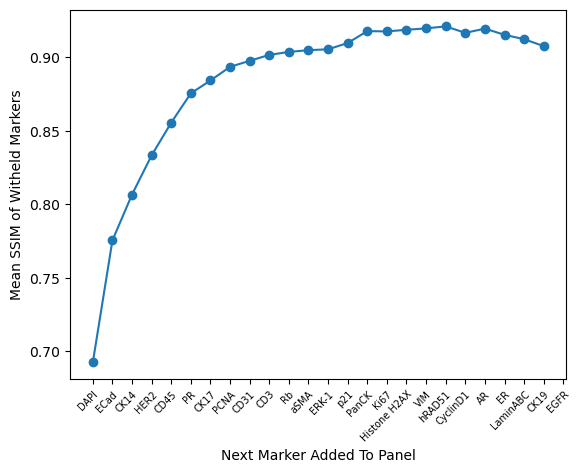

In [12]:
fig, ax = plt.subplots()
ax.plot(np.arange(24), [torch.mean(s).detach().cpu().numpy() for s in ssims], marker='o')
ax.set_xticks(np.arange(25), [ch2stain[i] for i in panel_order] + ['EGFR'], fontsize=7)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.xlabel('Next Marker Added To Panel')
plt.ylabel('Mean SSIM of Witheld Markers')
#plt.title('Influence of Individual Markers on Overall Prediction')
plt.savefig('htan_poster_figs/ssim.png')
plt.show()

# Plot Mean Intensities for Each Panel 

In [11]:
def plot_intensities(mints, pmints, masked_ch_idx, ch2stain):
    if mints.shape[1] == 1:
        stain_corrs = spearman(pmints.squeeze(), mints.squeeze())
        stain_corrs = stain_corrs.unsqueeze(0)
    else:
        stain_corrs = spearman(pmints, mints)
    #cls iteratively selected panel
    fig, ax = plt.subplots(1, len(masked_ch_idx), figsize=(12 * len(masked_ch_idx),12), layout='tight')
    for i,a in enumerate(fig.axes):

        a.set_title(f'{ch2stain[masked_ch_idx[i]]}\n(⍴={round(stain_corrs[i].item(),2)})', fontsize=120)
        x,y = mints[:10000,i].cpu(), pmints[:10000,i].cpu()
        # Calculate the point density
        xy = np.vstack([x,y])
        z = gaussian_kde(xy)(xy)
        a.scatter(x, y, c=z, s=10)
        #a.scatter(x,y)
        a.set_xticks([])
        a.set_yticks([])
        a.plot(np.arange(255), np.arange(255), linestyle='dashed', c='black')
    plt.savefig(f'htan_poster_figs/scatter_{len(unmasked_ch_idx)}_masked.png')
    plt.show()
    return stain_corrs

In [31]:
[unmasked_ch_idx[:9]

[0, 7, 16, 12, 14, 9, 18, 22, 24]

In [39]:
np.array([1,2,3])[[0,1,2]]

array([1, 2, 3])

In [14]:
stain_corrs = []
max_panel_size = 25
panel_sizes = [3, 6, 9, 12, 15, 18]
for size,(mints_, pmints_) in zip(panel_sizes, intensities):
#for panel,(mints_, pmints_) in zip(lukes_corr_panels, intensities):
    unmasked_ch_idx = panel_order[:size]
    #unmasked_ch_idx = panel
    masked_ch_idx = [i for i in range(max_panel_size) if i not in unmasked_ch_idx]
    print(masked_ch_idx)
    stain_corrs.append(plot_intensities(mints_, pmints_, masked_ch_idx, ch2stain))

In [40]:
stain_corrs = []
max_panel_size = 25
panel_sizes = [3, 6, 9, 12, 15, 18]
for size,(mints_, pmints_) in zip(panel_sizes, intensities):
#for panel,(mints_, pmints_) in zip(lukes_corr_panels, intensities):
    unmasked_ch_idx = panel_order[:size]
    #unmasked_ch_idx = panel
    masked_ch_idx = [i for i in range(max_panel_size) if i not in unmasked_ch_idx]
    #stain_corrs.append(plot_intensities(mints_, pmints_, masked_ch_idx, ch2stain))

In [13]:
stain_corrs = [s.detach().cpu().numpy() for s in stain_corrs]

In [14]:
masked_chs = []
for panel_size in range(1,25):
    msk_chs = [i for i in range(25) if i not in panel_order[:panel_size]]
    masked_chs.append(msk_chs)

corr_array = np.ones((25,25))
for i,(panel,panel_i) in enumerate(zip(stain_corrs,masked_chs)):
    if i == 23:
        panel = [panel.item()]
        panel_i = list(panel_i)
    for j,(ch, ch_i) in enumerate(zip(panel,panel_i)):
        corr_array[i][ch_i] = ch
        
iter_24_panel = panel_order
still_masked = [i for i in range(25) if i not in iter_24_panel]
sorted_channels = iter_24_panel + still_masked

corr_array_sorted = np.zeros(corr_array.shape)
ch2stain_sorted = {}
for i,ch in  enumerate(sorted_channels):
    corr_array_sorted[:,i] = corr_array[:,ch]
    ch2stain_sorted[i] = ch2stain[ch]

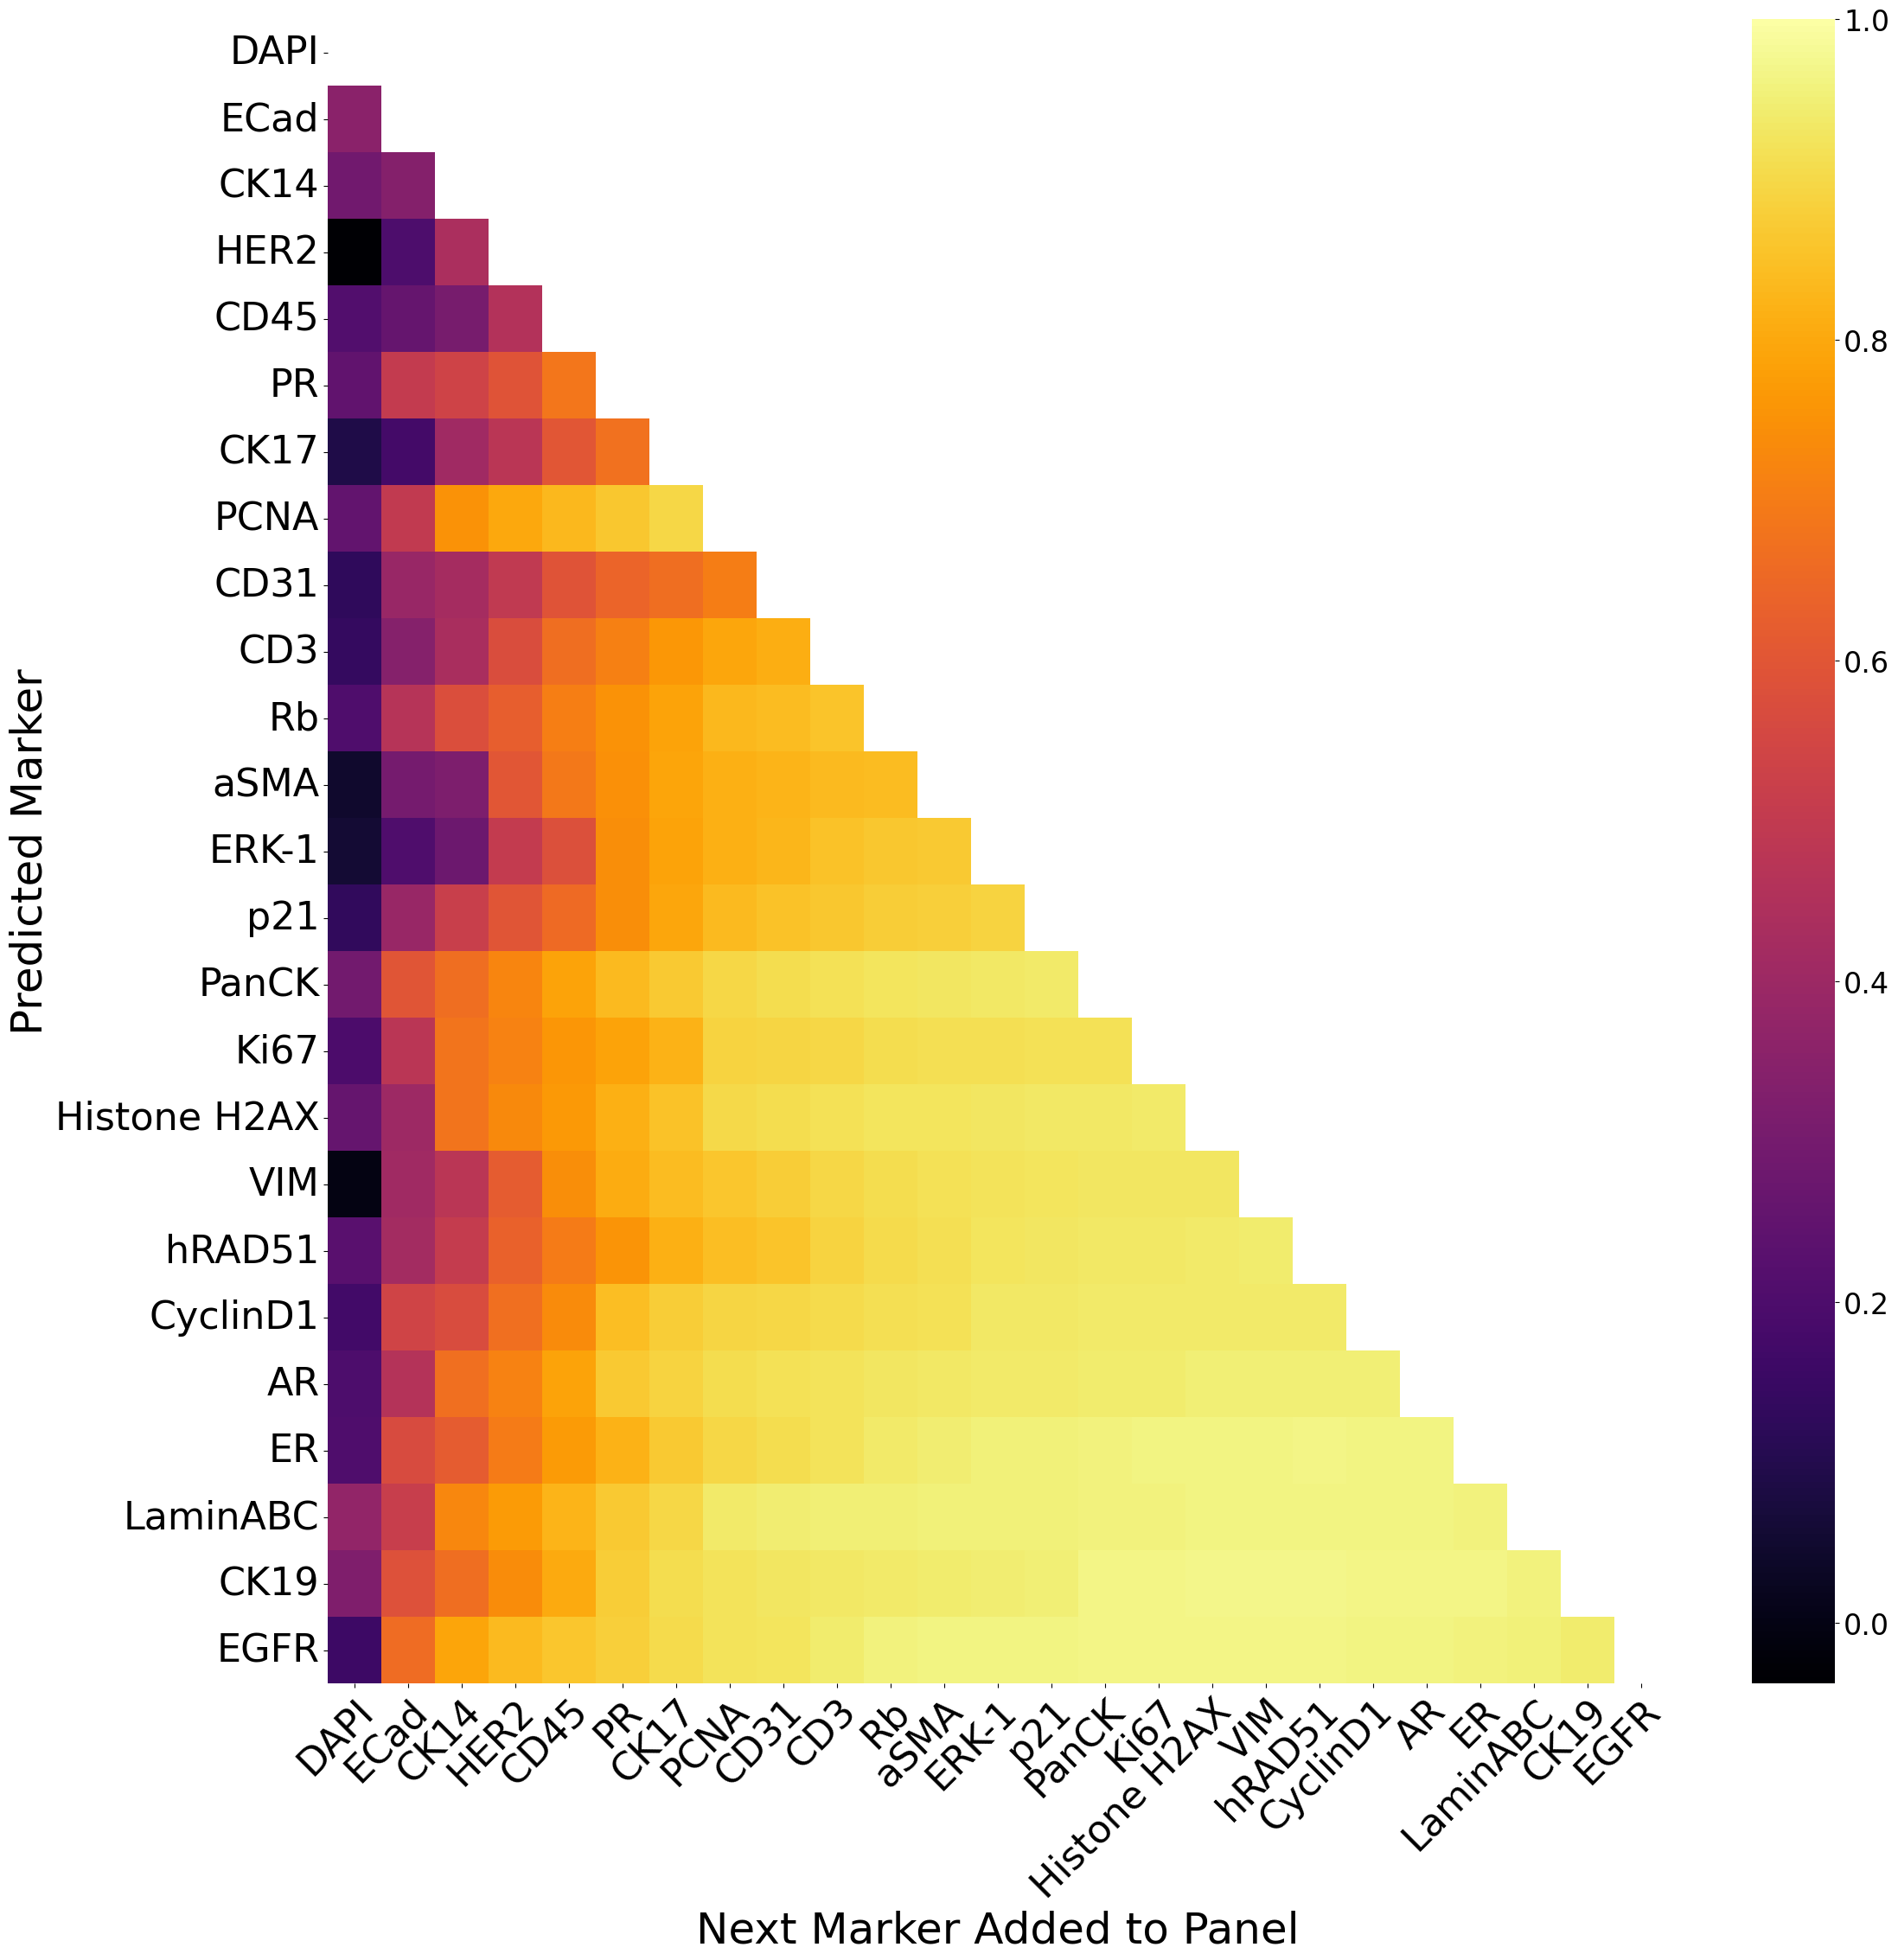

In [18]:
import seaborn as sns
import matplotlib.patches as patches
fig, ax = plt.subplots(figsize=(25,25))
img = corr_array_sorted[:25]
img = img.transpose()
#img = np.expand_dims(img, 0)
#im = ax.imshow(img, cmap='inferno', vmin=-0.4)
matrix = np.triu(img)
im = sns.heatmap(img, cmap='inferno', vmax=1, mask=matrix)
ax.set_xticks(np.arange(25) + 0.5,list(ch2stain_sorted.values()), fontsize=32)
ax.set_yticks(np.arange(25) + 0.5,list(ch2stain_sorted.values()), fontsize=32)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor")
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
im.collections[0].colorbar.ax.tick_params(labelsize=24)
# Create a Rectangle patch
rect = patches.Rectangle((5,1), 24,24, linewidth=1, edgecolor='w', facecolor='w')
# Add the patch to the Axes
#ax.add_patch(rect)
plt.xlabel('Next Marker Added to Panel', fontsize=36)
plt.ylabel('Predicted Marker', fontsize=36)
plt.savefig(f'htan_poster_figs/iter_selection.png', bbox_inches='tight')
plt.show()

In [22]:
mean_corrs = [np.mean(corrs) for corrs in stain_corrs]

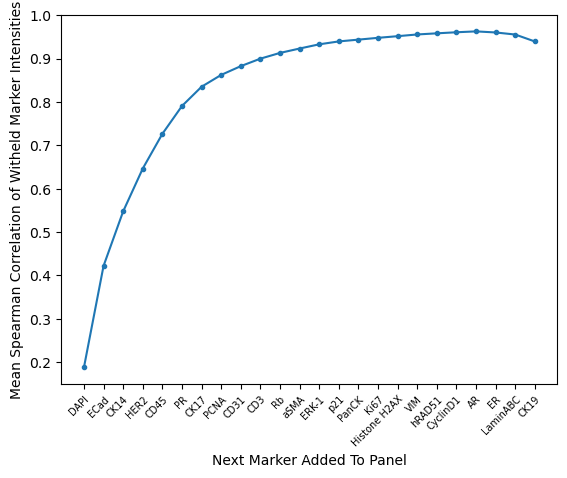

In [24]:
fig, ax = plt.subplots()
ax.plot(np.arange(24), mean_corrs, marker='.')
ax.set_xticks(np.arange(24), [ch2stain[i] for i in panel_order], fontsize=7)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.xlabel('Next Marker Added To Panel')
plt.ylabel('Mean Spearman Correlation of Witheld Marker Intensities')
#plt.title('Influence of Individual Markers on Overall Prediction')
plt.show()

(-122.40535774230958, 90.22064247131348, -92.2294979095459, 100.57560539245605)

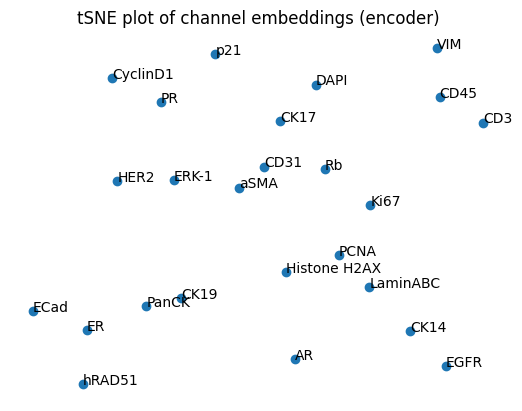

In [18]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=3).fit_transform(model.mae.encoder.pos_embedding.detach().cpu().numpy()[0][1:])
X = tsne[:,0]
Y = tsne[:,1]

fig, ax = plt.subplots()
ax.scatter(X, Y)

for i in range(25):
    ax.annotate((ch2stain[i]), (X[i], Y[i]))
plt.title('tSNE plot of channel embeddings (encoder)')
ax.axis('off')

(-51.53648147583008, 73.55959854125976, -49.97414054870605, 58.117702865600585)

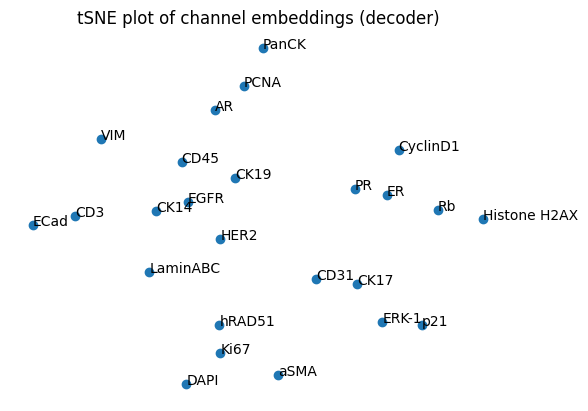

In [19]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=3).fit_transform(model.mae.decoder_pos_emb(torch.tensor([i for i in range(0,25)], device=device)).detach().cpu())
X = tsne[:,0]
Y = tsne[:,1]

fig, ax = plt.subplots()
ax.scatter(X, Y)

for i in range(25):
    ax.annotate((ch2stain[i]), (X[i], Y[i]))
plt.title('tSNE plot of channel embeddings (decoder)')
ax.axis('off')